In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [2]:
from training.training import *
from common.utils import load_sql_to_df, save_to_sql, plot_history

import datasets
import data_process as dp
from models.sentiment_analysis import SentimentAnalysisLSTM, SentimentAnalysisGRU, SentimentAnalysisRNN

import numpy as np
import pandas as pd
import sqlite3 as db
import torchtext
import torch
import torch.utils
import matplotlib.pyplot as plt
from langdetect import detect_langs, detect
from tqdm import tqdm_notebook

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [12]:
#reproducibility
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

## Load data

In [13]:
important_columns = ["position", "move", "comment", "sentiment"]
gameknot_moves_df = load_sql_to_df("SELECT * FROM english_annotated_moves", "../../chess.db")[important_columns]
angelfire_moves = load_sql_to_df("SELECT * FROM angelfire_moves", "../../chess.db")[['position', 'move', 'comment']]
angelfire_moves['sentiment'] = -1
gameknot_moves_df

,position,move,comment,sentiment
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,2
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",-1
2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,-1
3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",-1
4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",0
...,...,...,...,...
326634,rnb5/p2p1P1N/7p/1pR5/6P1/4k3/2P1B3/3Q1RK1 b - ...,b5b4,Pawn,-1
326635,rnb5/p2p1P1N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f7f8q,Check mate in two moves,-1
326636,rnb2Q2/p2p3N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 b -...,d7d6,Pawn,-1
326637,rnb2Q2/p6N/3p3p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f8e8,Check,-1


In [14]:
chessbase_moves_df = load_sql_to_df("SELECT * FROM chessbase_moves_with_comments_2", "../../chess.db")
# chessbase_moves_df = chessbase_moves_df[chessbase_moves_df.is_english == 1][important_columns]
chessbase_moves_df = chessbase_moves_df[important_columns]
chessbase_moves_df

,position,move,comment,sentiment
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,La plus ancienne partie connue aprčs la réform...,-1
1,r1bqkb1r/ppp2ppp/2n2n2/3Pp1N1/2B5/8/PPPP1PPP/R...,f6d5,Nous ne mettons pas de point d'interrogation u...,-1
2,r1bqkb1r/ppp2ppp/2n5/3np1N1/2B5/8/PPPP1PPP/RNB...,g5f7,Ce point d'exclamation ne signifie pas non\npl...,1
3,r1bq1b1r/ppp3pp/2n1k3/3np3/2B5/2N2Q2/PPPP1PPP/...,c6b4,Déjŕ STEINITZ avait renforcé avec Nb4,-1
4,r1bq1b1r/ppn2kpp/2p5/3np3/2BPQB2/P1N5/1PP2PPP/...,f4e5,"Et comme dit EUWE, il faut encore prouver que ...",-1
...,...,...,...,...
1633578,rnbqk1nr/pppp1ppp/4p3/8/1bP5/2N5/PP1PPPPP/R1BQ...,e2e4,is a principled alternative. ist eine\nprinzip...,-1
1633579,rnbqk1nr/pppp1ppp/4p3/8/1bP1P3/2N5/PP1P1PPP/R1...,g8e7,The best move. Der beste Zug.,-1
1633580,rnbq1rk1/pp1pnppp/4p3/2pP4/2P1P3/2P2N2/P4PPP/R...,d7d6,leads to a complicated position with chances f...,-1
1633581,r1bqk1nr/pp1p1ppp/2n1p3/2p5/2P1P3/P1P5/1P3PPP/...,f1d3,with a clear long-term advantage for White. mi...,-1


In [15]:
moves_df = pd.concat((gameknot_moves_df, chessbase_moves_df, angelfire_moves), axis=0)
# moves_df = gameknot_moves_df
moves_df

,position,move,comment,sentiment
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,2
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",-1
2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,-1
3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",-1
4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",0
...,...,...,...,...
27500,2Q2b1k/1p3q2/p6p/5n2/3p1r2/5NR1/PP3K2/7R w - -...,g3h3,"White defends very\nactively, with his major p...",-1
27501,2Q2b1k/1p3q2/p6p/5n2/3p1r2/5N1R/PP3K2/7R b - -...,d4d3,"A decoy, to tempt the White Queen\naway from t...",-1
27502,5b1k/1p6/p6p/5n2/5r2/3Q1N1R/P3K3/q6R b - - 3 43,a1a2,And this brings about a very unusual middlegam...,-1
27503,5b1k/1p6/p6p/5n2/5r2/3Q3R/q2NK3/7R b - - 1 44,f4d4,Consistent chess. Black hammers away at the\nw...,-1


## Preprocessing

In [16]:
glove_50 = torchtext.vocab.GloVe(name="6B", dim=50, cache="../../.vector_cache/")
glove_100 = torchtext.vocab.GloVe(name="6B", dim=100, cache="../../.vector_cache/")
glove_200 = torchtext.vocab.GloVe(name="6B", dim=200, cache="../../.vector_cache/")
glove_300 = torchtext.vocab.GloVe(name="6B", dim=300, cache="../../.vector_cache/")

datasets.add_padding_vector_to_embeddings(glove_50)
datasets.add_padding_vector_to_embeddings(glove_100)
datasets.add_padding_vector_to_embeddings(glove_200)
datasets.add_padding_vector_to_embeddings(glove_300)

In [17]:
glove_embbedings = glove_50

In [28]:
data_processing = dp.DataProcessing(vocab=glove_50.stoi, max_len=120,tokenize_fun=dp.nltk_tokenize)

In [30]:
moves_df_to_pred = data_processing.prepare_data_for_sentiment_analysis_prediction(moves_df)
moves_df_to_pred

,position,move,comment,sentiment,preprocessed_comment
605188,r2r2k1/2q1bppp/3ppn2/pB3P2/P3P3/2B5/1P2Q1PP/3R...,e6e5,what else,-1,"[what, else]"
652335,3q1bk1/3b4/pp5p/4p1p1/2P1N3/P1N2rP1/5P1P/1RBR2...,c3d5,"[%csl Gb6,Rd7][%cal Gd1d8,Gd5b6,Gb1b6]\nWith d...",-1,"[with, domination]"
606273,r4r2/ppp3kp/2n3p1/3qp3/3p2P1/3P3P/PPPQNP2/4RRK...,f2f4,"King-Rowson, 1994",-1,"[king, rowson]"
10410,rnbqkb1r/ppp2p1p/5n2/3PN3/2B2ppP/8/PPPP2P1/RNB...,f8d6,\nRice Gambit,-1,"[rice, gambit]"
811724,2kr1b1r/p4pp1/2q1pn1p/1pp5/3P1P1P/2B3N1/PPP1Q1...,c5c4,"1/2:1/2\nKhurschiov-Svetushkin, ULIM Cup Kishn...",-1,"[cup, mda]"
...,...,...,...,...,...
320552,rn1qkbnr/ppp2ppp/4p3/3p1b2/2PP4/2N2N2/PP2PPPP/...,f8b4,"Having said that, I'm not surprised to see Mar...",-1,"[having, said, that, i, 'm, not, surprised, to..."
189500,r1bqk2r/1ppn1ppp/5n2/p1bPp1B1/2P1P3/P1N2N2/1P4...,d1a4,My opponent took another large amount of time ...,-1,"[my, opponent, took, another, large, amount, o..."
285987,3qrrk1/p3bppp/3p4/1ppNnPPn/8/P3B2P/1PP1QPB1/2K...,h5g3,There really aren't any great moves here. Blac...,-1,"[there, really, are, n't, any, great, moves, h..."
296649,rnbq1b1r/ppp1pkpp/3p1n2/8/4P3/2N5/PPPP1PPP/R1B...,e7e5,"while a normal central control move in a ""norm...",-1,"[while, a, normal, central, control, move, in,..."


In [31]:
comments_df = data_processing.prepare_data_for_sentiment_analysis_training(moves_df)
comments_df

,comment,sentiment,preprocessed_comment
136694,because of,0,"[because, of]"
62758,"Finkel,A",1,"[finkel, a]"
186121,Much simpler,1,"[much, simpler]"
64026,"1-0 Ivanchuk,V-Kotronias,V/Lvov 1988 (38)",1,"[ivanchuk, lvov]"
168557,"sin\nproblemas aparentes,",1,"[sin, problemas]"
...,...,...,...
1726,"! the icing on the cake, now the black queen i...",1,"[!, the, icing, on, the, cake, now, the, black..."
222285,"I try to defend everything I have, but to no a...",0,"[i, try, to, defend, everything, i, have, but,..."
5066,"! If 10...h6, I would not have been able to pl...",1,"[!, if, i, would, not, have, been, able, to, p..."
9196,"!! By my books, this is a killer move right he...",1,"[!, !, by, my, books, this, is, a, killer, mov..."


In [32]:
train_df, test_df = dp.df_train_test_split(comments_df, comment_col='preprocessed_comment', test_size=0.05)
display(train_df)
display(test_df)

,comment,sentiment,preprocessed_comment
46973,"Levitina,\nI-Chekhova-Kostina,T/Tbilisi/1985/0...",1,"[i, tbilisi]"
75337,\nand if,1,"[and, if]"
34521,Tolnai - Tatai\nBudapest 1988,0,"[tolnai, budapest]"
87749,fails to,0,"[fails, to]"
127410,\npreventing f4-f5. After,1,"[preventing, after]"
...,...,...,...
226113,"But, I sac it. The idea being is that if Tom t...",0,"[but, i, sac, it, ., the, idea, being, is, tha..."
225696,Instead of retreating back to d2 (which I shou...,0,"[instead, of, retreating, back, to, which, i, ..."
9818,"?? I was lost anyway, but this is now resignab...",0,"[?, ?, i, was, lost, anyway, but, this, is, no..."
6033,?? Because his DSB is placed directly in front...,0,"[?, ?, because, his, dsb, is, placed, directly..."


,comment,sentiment,preprocessed_comment
201888,\nthreatening Bxh6 and Rxb4,1,"[threatening, and]"
94644,falls into,0,"[falls, into]"
165280,\nloses after,0,"[loses, after]"
98891,stalemate.,0,"[stalemate, .]"
180897,\nruns into,0,"[runs, into]"
...,...,...,...
217915,The pin is quite unpleasant. The main point is...,1,"[the, pin, is, quite, unpleasant, ., the, main..."
221953,"If 10...h6, I would not have been able to play...",1,"[if, i, would, not, have, been, able, to, play..."
144230,"A terrible blunder, since White wasn't really ...",0,"[a, terrible, blunder, since, white, was, n't,..."
211617,"\nhas one problem: Yes, everything is solididl...",1,"[has, one, problem, yes, everything, is, prote..."


In [33]:
train_dataset = datasets.PretrainedEmbeddingsIndicesDataset(train_df, glove_embbedings, comment_col='preprocessed_comment')
test_dataset = datasets.PretrainedEmbeddingsIndicesDataset(test_df, glove_embbedings,  comment_col='preprocessed_comment')

## Comments' length

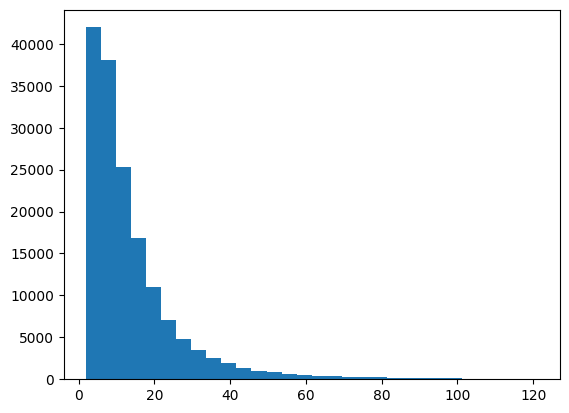

In [34]:
lengths = [len(x) for x,_ in train_dataset]
plt.hist(lengths, bins=30)
plt.show()

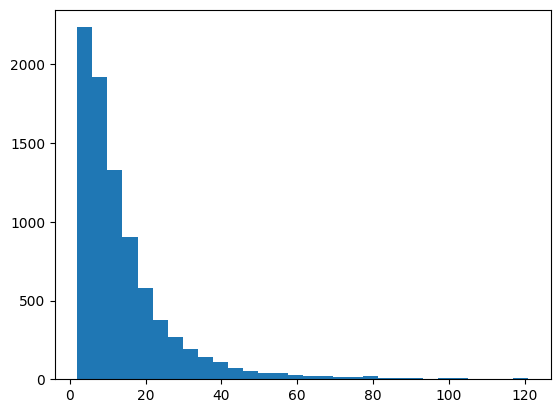

In [35]:
lengths = [len(x) for x,_ in test_dataset]
plt.hist(lengths, bins=30)
plt.show()

## Training

In [36]:
batch_size = 256

train_loader = datasets.DataLoaderPadding(dataset=train_dataset, batch_size=batch_size)
test_loader = datasets.DataLoaderPadding(dataset=test_dataset, batch_size=batch_size)

In [48]:
model = SentimentAnalysisLSTM(embeddings=glove_200, hidden_dim=16, num_layers=2, bidirectional=True, dropout=0.2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.9)
model

SentimentAnalysisLSTM(
  (embedding): Embedding(400001, 200)
  (lstm): LSTM(200, 16, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [49]:
trainer = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler)

In [55]:
trainer.train(70, verbose=True)

Epoch 71/140
Train loss: 0.227683, accuracy: 90.89%
Val loss:   0.321076, accuracy: 86.63%
-----------------------------
Epoch 72/140
Train loss: 0.226642, accuracy: 90.88%
Val loss:   0.329265, accuracy: 87.24%
-----------------------------
Epoch 73/140
Train loss: 0.225628, accuracy: 90.98%
Val loss:   0.336619, accuracy: 86.44%
-----------------------------
Epoch 74/140
Train loss: 0.226118, accuracy: 90.93%
Val loss:   0.336308, accuracy: 87.20%
-----------------------------
Epoch 75/140
Train loss: 0.225144, accuracy: 90.97%
Val loss:   0.328197, accuracy: 87.24%
-----------------------------
Epoch 76/140
Train loss: 0.224796, accuracy: 91.00%
Val loss:   0.327547, accuracy: 86.37%
-----------------------------
Epoch 77/140
Train loss: 0.223647, accuracy: 91.01%
Val loss:   0.355518, accuracy: 85.70%
-----------------------------
Epoch 78/140
Train loss: 0.223828, accuracy: 91.05%
Val loss:   0.336848, accuracy: 86.10%
-----------------------------
Epoch 79/140
Train loss: 0.22402

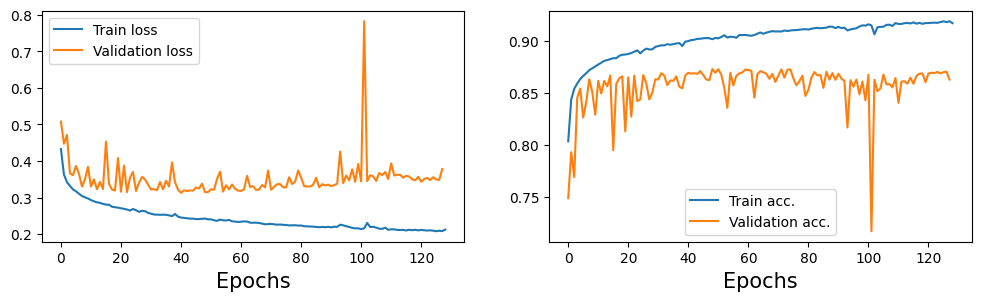

In [56]:
trainer.plot_history()

In [61]:
trainer.best_model()


Loading best params on validation set (epoch 49, accuracy: 87.26%)



SentimentAnalysisLSTM(
  (embedding): Embedding(400001, 200)
  (lstm): LSTM(200, 16, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [47]:
best_model = trainer.best_model()
best_model.lstm.flatten_parameters()


Loading best params on validation set (epoch 25, accuracy: 87.49%)



In [42]:
model_2 = SentimentAnalysisGRU(embeddings=glove_100, hidden_dim=32, num_layers=1, bidirectional=True, dropout=0.1)
model_2.to(device)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001)
model_2

SentimentAnalysisGRU(
  (embedding): Embedding(400001, 100)
  (lstm): GRU(100, 32, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [43]:
trainer_2 = Trainer(model=model_2, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer_2)

In [44]:
trainer_2.train(100, verbose=True)

Epoch 1/100
Train loss: 0.430977, accuracy: 80.58%
Val loss:   0.442722, accuracy: 79.42%
-----------------------------
Epoch 2/100
Train loss: 0.369275, accuracy: 83.92%
Val loss:   0.393675, accuracy: 82.77%
-----------------------------
Epoch 3/100
Train loss: 0.345331, accuracy: 85.13%
Val loss:   0.435094, accuracy: 79.22%
-----------------------------
Epoch 4/100
Train loss: 0.329483, accuracy: 85.86%
Val loss:   0.479034, accuracy: 76.23%
-----------------------------
Epoch 5/100
Train loss: 0.317712, accuracy: 86.49%
Val loss:   0.411300, accuracy: 80.80%
-----------------------------
Epoch 6/100
Train loss: 0.309038, accuracy: 86.94%
Val loss:   0.459101, accuracy: 77.71%
-----------------------------
Epoch 7/100
Train loss: 0.302045, accuracy: 87.26%
Val loss:   0.399146, accuracy: 81.82%
-----------------------------
Epoch 8/100
Train loss: 0.295302, accuracy: 87.58%
Val loss:   0.369393, accuracy: 83.91%
-----------------------------
Epoch 9/100
Train loss: 0.289197, accura

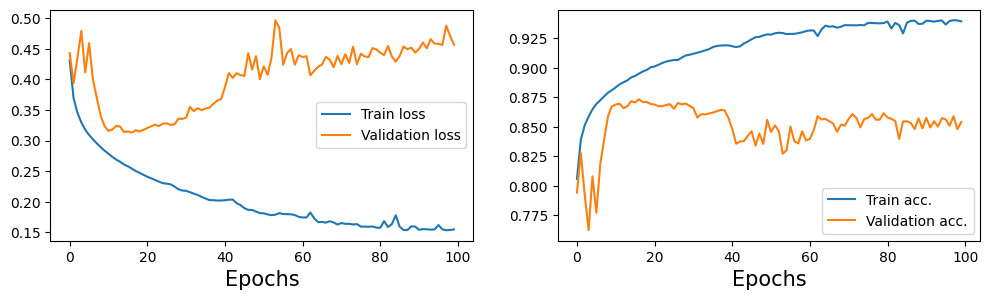

In [45]:
trainer_2.plot_history()

In [46]:
trainer_2.best_model()


Loading best params on validation set (epoch 17, accuracy: 87.34%)



SentimentAnalysisGRU(
  (embedding): Embedding(400001, 100)
  (lstm): GRU(100, 32, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [50]:
best_model = trainer_2.best_model()
best_model.lstm.flatten_parameters()


Loading best params on validation set (epoch 13, accuracy: 90.38%)



In [30]:
# torch.save(best_model.state_dict(), "../../models/best_LSTM_state_dict.model")
state_dict = torch.load( "../../models/best_LSTM_state_dict.model")
# state_dict
model_2.load_state_dict(state_dict)

<All keys matched successfully>

In [62]:
model_3 = SentimentAnalysisGRU(embeddings=glove_300, hidden_dim=16, num_layers=3, bidirectional=True, dropout=0.5)
model_3.to(device)
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.001)
model_3

SentimentAnalysisGRU(
  (embedding): Embedding(400001, 300)
  (lstm): GRU(300, 16, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [63]:
trainer_3 = Trainer(model=model_3, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer_3)

In [64]:
trainer_3.train(50, verbose=True)

Epoch 1/50
Train loss: 0.433929, accuracy: 80.83%
Val loss:   0.484660, accuracy: 77.95%
-----------------------------
Epoch 2/50
Train loss: 0.364455, accuracy: 84.52%
Val loss:   0.392067, accuracy: 82.95%
-----------------------------
Epoch 3/50
Train loss: 0.340281, accuracy: 85.73%
Val loss:   0.373673, accuracy: 83.96%
-----------------------------
Epoch 4/50
Train loss: 0.326413, accuracy: 86.25%
Val loss:   0.348362, accuracy: 85.69%
-----------------------------
Epoch 5/50
Train loss: 0.314235, accuracy: 86.81%
Val loss:   0.333799, accuracy: 86.04%
-----------------------------
Epoch 6/50
Train loss: 0.306479, accuracy: 87.26%
Val loss:   0.326244, accuracy: 86.00%
-----------------------------
Epoch 7/50
Train loss: 0.299292, accuracy: 87.58%
Val loss:   0.325044, accuracy: 85.79%
-----------------------------
Epoch 8/50
Train loss: 0.292321, accuracy: 87.94%
Val loss:   0.317926, accuracy: 86.56%
-----------------------------
Epoch 9/50
Train loss: 0.287013, accuracy: 88.14

In [65]:
trainer_3.best_model()


Loading best params on validation set (epoch 13, accuracy: 87.40%)



SentimentAnalysisGRU(
  (embedding): Embedding(400001, 300)
  (lstm): GRU(300, 16, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

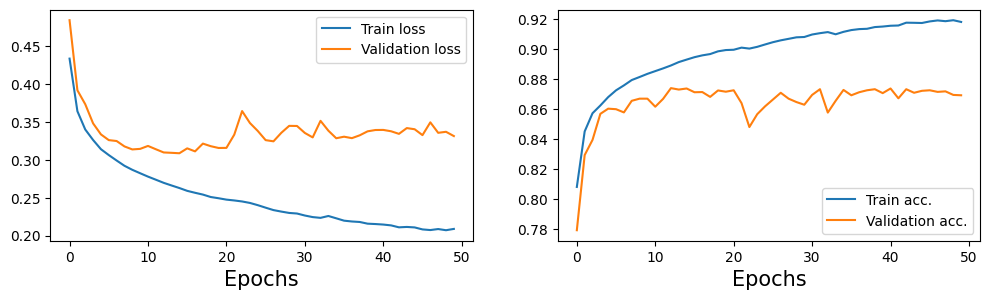

In [66]:
trainer_3.plot_history()

In [79]:
torch.save(best_model.state_dict(), "../../models/best_LSTM_state_dict.model")

## Testing

In [44]:
best_model = model_2
best_model.to(device)
trainer_2.validation(best_model)

(0.21502440703882775, 0.9158211794546608)

In [46]:
trainer_2.validation(best_model, trainer_2.train_dataLoader)

(0.20252574563145792, 0.9200884475781217)

In [67]:
# moves_df_with_preprocessed_comments = data_processing.prepare_data_for_sentiment_analysis_prediction(moves_df)
moves_df_with_preprocessed_comments = moves_df_to_pred
moves_df_with_preprocessed_comments

,position,move,comment,sentiment,preprocessed_comment
605188,r2r2k1/2q1bppp/3ppn2/pB3P2/P3P3/2B5/1P2Q1PP/3R...,e6e5,what else,-1,"[what, else]"
652335,3q1bk1/3b4/pp5p/4p1p1/2P1N3/P1N2rP1/5P1P/1RBR2...,c3d5,"[%csl Gb6,Rd7][%cal Gd1d8,Gd5b6,Gb1b6]\nWith d...",-1,"[with, domination]"
606273,r4r2/ppp3kp/2n3p1/3qp3/3p2P1/3P3P/PPPQNP2/4RRK...,f2f4,"King-Rowson, 1994",-1,"[king, rowson]"
10410,rnbqkb1r/ppp2p1p/5n2/3PN3/2B2ppP/8/PPPP2P1/RNB...,f8d6,\nRice Gambit,-1,"[rice, gambit]"
811724,2kr1b1r/p4pp1/2q1pn1p/1pp5/3P1P1P/2B3N1/PPP1Q1...,c5c4,"1/2:1/2\nKhurschiov-Svetushkin, ULIM Cup Kishn...",-1,"[cup, mda]"
...,...,...,...,...,...
320552,rn1qkbnr/ppp2ppp/4p3/3p1b2/2PP4/2N2N2/PP2PPPP/...,f8b4,"Having said that, I'm not surprised to see Mar...",-1,"[having, said, that, i, 'm, not, surprised, to..."
189500,r1bqk2r/1ppn1ppp/5n2/p1bPp1B1/2P1P3/P1N2N2/1P4...,d1a4,My opponent took another large amount of time ...,-1,"[my, opponent, took, another, large, amount, o..."
285987,3qrrk1/p3bppp/3p4/1ppNnPPn/8/P3B2P/1PP1QPB1/2K...,h5g3,There really aren't any great moves here. Blac...,-1,"[there, really, are, n't, any, great, moves, h..."
296649,rnbq1b1r/ppp1pkpp/3p1n2/8/4P3/2N5/PPPP1PPP/R1B...,e7e5,"while a normal central control move in a ""norm...",-1,"[while, a, normal, central, control, move, in,..."


In [68]:
moves_df_with_preprocessed_comments = moves_df_with_preprocessed_comments.reset_index()
moves_df_with_preprocessed_comments

,index,position,move,comment,sentiment,preprocessed_comment
0,605188,r2r2k1/2q1bppp/3ppn2/pB3P2/P3P3/2B5/1P2Q1PP/3R...,e6e5,what else,-1,"[what, else]"
1,652335,3q1bk1/3b4/pp5p/4p1p1/2P1N3/P1N2rP1/5P1P/1RBR2...,c3d5,"[%csl Gb6,Rd7][%cal Gd1d8,Gd5b6,Gb1b6]\nWith d...",-1,"[with, domination]"
2,606273,r4r2/ppp3kp/2n3p1/3qp3/3p2P1/3P3P/PPPQNP2/4RRK...,f2f4,"King-Rowson, 1994",-1,"[king, rowson]"
3,10410,rnbqkb1r/ppp2p1p/5n2/3PN3/2B2ppP/8/PPPP2P1/RNB...,f8d6,\nRice Gambit,-1,"[rice, gambit]"
4,811724,2kr1b1r/p4pp1/2q1pn1p/1pp5/3P1P1P/2B3N1/PPP1Q1...,c5c4,"1/2:1/2\nKhurschiov-Svetushkin, ULIM Cup Kishn...",-1,"[cup, mda]"
...,...,...,...,...,...,...
1323028,320552,rn1qkbnr/ppp2ppp/4p3/3p1b2/2PP4/2N2N2/PP2PPPP/...,f8b4,"Having said that, I'm not surprised to see Mar...",-1,"[having, said, that, i, 'm, not, surprised, to..."
1323029,189500,r1bqk2r/1ppn1ppp/5n2/p1bPp1B1/2P1P3/P1N2N2/1P4...,d1a4,My opponent took another large amount of time ...,-1,"[my, opponent, took, another, large, amount, o..."
1323030,285987,3qrrk1/p3bppp/3p4/1ppNnPPn/8/P3B2P/1PP1QPB1/2K...,h5g3,There really aren't any great moves here. Blac...,-1,"[there, really, are, n't, any, great, moves, h..."
1323031,296649,rnbq1b1r/ppp1pkpp/3p1n2/8/4P3/2N5/PPPP1PPP/R1B...,e7e5,"while a normal central control move in a ""norm...",-1,"[while, a, normal, central, control, move, in,..."


In [76]:
best_model.cuda()
unlabeled_dataset = datasets.PretrainedEmbeddingsIndicesDataset(moves_df_with_preprocessed_comments, glove_embbedings, comment_col="preprocessed_comment")
unlabeled_loader = datasets.DataLoaderPadding(dataset=unlabeled_dataset, batch_size = 128)
predictions = predict(unlabeled_loader, best_model, low_boundary=0.45)
moves_df_with_preprocessed_comments.loc[:, "sentiment"] = predictions.numpy().astype(np.int32)
moves_df_with_preprocessed_comments

,index,position,move,comment,sentiment,preprocessed_comment
0,605188,r2r2k1/2q1bppp/3ppn2/pB3P2/P3P3/2B5/1P2Q1PP/3R...,e6e5,what else,1,"[what, else]"
1,652335,3q1bk1/3b4/pp5p/4p1p1/2P1N3/P1N2rP1/5P1P/1RBR2...,c3d5,"[%csl Gb6,Rd7][%cal Gd1d8,Gd5b6,Gb1b6]\nWith d...",1,"[with, domination]"
2,606273,r4r2/ppp3kp/2n3p1/3qp3/3p2P1/3P3P/PPPQNP2/4RRK...,f2f4,"King-Rowson, 1994",1,"[king, rowson]"
3,10410,rnbqkb1r/ppp2p1p/5n2/3PN3/2B2ppP/8/PPPP2P1/RNB...,f8d6,\nRice Gambit,1,"[rice, gambit]"
4,811724,2kr1b1r/p4pp1/2q1pn1p/1pp5/3P1P1P/2B3N1/PPP1Q1...,c5c4,"1/2:1/2\nKhurschiov-Svetushkin, ULIM Cup Kishn...",1,"[cup, mda]"
...,...,...,...,...,...,...
1323028,320552,rn1qkbnr/ppp2ppp/4p3/3p1b2/2PP4/2N2N2/PP2PPPP/...,f8b4,"Having said that, I'm not surprised to see Mar...",1,"[having, said, that, i, 'm, not, surprised, to..."
1323029,189500,r1bqk2r/1ppn1ppp/5n2/p1bPp1B1/2P1P3/P1N2N2/1P4...,d1a4,My opponent took another large amount of time ...,1,"[my, opponent, took, another, large, amount, o..."
1323030,285987,3qrrk1/p3bppp/3p4/1ppNnPPn/8/P3B2P/1PP1QPB1/2K...,h5g3,There really aren't any great moves here. Blac...,1,"[there, really, are, n't, any, great, moves, h..."
1323031,296649,rnbq1b1r/ppp1pkpp/3p1n2/8/4P3/2N5/PPPP1PPP/R1B...,e7e5,"while a normal central control move in a ""norm...",1,"[while, a, normal, central, control, move, in,..."


In [77]:
classified_comments = moves_df_with_preprocessed_comments[moves_df_with_preprocessed_comments.sentiment.isin([0,1])].reset_index()
classified_comments

,level_0,index,position,move,comment,sentiment,preprocessed_comment
0,0,605188,r2r2k1/2q1bppp/3ppn2/pB3P2/P3P3/2B5/1P2Q1PP/3R...,e6e5,what else,1,"[what, else]"
1,1,652335,3q1bk1/3b4/pp5p/4p1p1/2P1N3/P1N2rP1/5P1P/1RBR2...,c3d5,"[%csl Gb6,Rd7][%cal Gd1d8,Gd5b6,Gb1b6]\nWith d...",1,"[with, domination]"
2,2,606273,r4r2/ppp3kp/2n3p1/3qp3/3p2P1/3P3P/PPPQNP2/4RRK...,f2f4,"King-Rowson, 1994",1,"[king, rowson]"
3,3,10410,rnbqkb1r/ppp2p1p/5n2/3PN3/2B2ppP/8/PPPP2P1/RNB...,f8d6,\nRice Gambit,1,"[rice, gambit]"
4,4,811724,2kr1b1r/p4pp1/2q1pn1p/1pp5/3P1P1P/2B3N1/PPP1Q1...,c5c4,"1/2:1/2\nKhurschiov-Svetushkin, ULIM Cup Kishn...",1,"[cup, mda]"
...,...,...,...,...,...,...,...
1277123,1323028,320552,rn1qkbnr/ppp2ppp/4p3/3p1b2/2PP4/2N2N2/PP2PPPP/...,f8b4,"Having said that, I'm not surprised to see Mar...",1,"[having, said, that, i, 'm, not, surprised, to..."
1277124,1323029,189500,r1bqk2r/1ppn1ppp/5n2/p1bPp1B1/2P1P3/P1N2N2/1P4...,d1a4,My opponent took another large amount of time ...,1,"[my, opponent, took, another, large, amount, o..."
1277125,1323030,285987,3qrrk1/p3bppp/3p4/1ppNnPPn/8/P3B2P/1PP1QPB1/2K...,h5g3,There really aren't any great moves here. Blac...,1,"[there, really, are, n't, any, great, moves, h..."
1277126,1323031,296649,rnbq1b1r/ppp1pkpp/3p1n2/8/4P3/2N5/PPPP1PPP/R1B...,e7e5,"while a normal central control move in a ""norm...",1,"[while, a, normal, central, control, move, in,..."


In [75]:
classified_comments_to_save = classified_comments[['position', 'move', 'comment', 'sentiment']]
save_to_sql(classified_comments_to_save, "../../chess.db", "all_clasified_moves", if_exists='replace')